In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pystan
import matplotlib.pyplot as plt
from pandas import Timestamp
from scipy.special import logit
from scipy.special import expit as sigmoid

from sys import getsizeof

In [3]:
pystan.__version__

'2.19.0.0'

## Model code - to be moved out

In [4]:
revenue_model = """
data {
  int<lower=0> N;   //observations         
  int<lower=0> C;   //conversion_count;
  real<lower=0> prior_alpha;
  real<lower=0> prior_beta;
  real r[C];         //observed revenue
}

parameters {
  real<lower=0, upper=0.8> lambda;
  real<lower=0> theta;
}

model {
  lambda ~ beta(prior_alpha, prior_beta);
  C ~ binomial(N, lambda);
  for (n in 1:C){
   r[n] ~ exponential(theta);
  }
}

generated quantities {
  real<lower=0> gtv_per_participant;
  real<lower=0> aov;
  gtv_per_participant = lambda * 1 / theta;
  aov = 1/ theta;

}
  
"""

conversion_model = """
data {
  int<lower=0> observations;            
  int<lower=0> observation_conversion_count;
  real<lower=0> prior_alpha;
  real<lower=0> prior_beta;
}

parameters {
  real<lower=0, upper=0.8> theta;
}

model {
  theta ~ beta(prior_alpha, prior_beta);
  observation_conversion_count ~ binomial(observations, theta);
}

"""

In [5]:
sm_revenue = pystan.StanModel(file='revenue_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e10b5aaf0bda8c3fd55c449a8894ff67 NOW.


In [8]:
sm_revenue

In [6]:
sm_conversion = pystan.StanModel(file = 'conversion_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d81218ddedd2117198748e31e848d70 NOW.


In [3]:
sm_revenue = pystan.StanModel(model_code=revenue_model)
sm_conversion = pystan.StanModel(model_code = conversion_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5dbfe769d236f77f7f6ff82a90f9df02 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97f75449d47461cb90cfbe6583c57f7b NOW.


In [4]:
getsizeof(globals())

2288

In [5]:
sm_revenue

In [13]:
ts = date_range[0]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, 'conversion', False)

nan


/Users/juersong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


nan
loss if choosing variant1: 0.13292589410143144
loss if choosing variant2: 0.13487739412370162


In [14]:
getsizeof(globals())

2288

In [16]:
ts = date_range[1]
closs, tloss = calc_stats_between_buckets_for_column(df, ts, 'conversion', False)

0.06970128022759602
0.0642504118616145
loss if choosing variant1: 0.0005370416307585591
loss if choosing variant2: 0.006061444966540325


In [17]:
getsizeof(globals())

2288

## Util functions

In [3]:
def RunModel(df: pd.DataFrame, ts: Timestamp, model: pystan.model.StanModel, model_type: str, prior_alpha=1, prior_beta=1):
    """
    Parameters:
    df: input dataframe. 
    ts: date
    model: StanModel
    model_type: 'conversion' or 'revenue'
    
    Return:
    Result
    """
    
    # pull out data before ts
    dt = pd.to_datetime(df['participation_timestamp_rounded_up'])
    idx = dt < Timestamp(ts)
    subxp = df.loc[idx]

    y = subxp['is_converted'].values.astype(np.int64)
    converted = subxp[subxp['is_converted']== 1]
    
    if(model_type == 'conversion'):
        # Point estimates:
        print(y.sum()/len(y))
      
        # use an uninformed prior for lambda, uniform on the interval [0, 1]
        dat = {
            'observations': len(y),
            'observation_conversion_count': y.sum(),
            'prior_alpha' : prior_alpha,
            'prior_beta': prior_beta
        }
 
    elif(model_type == 'revenue'):
        r = converted['data'].values

        # Point estimates:
        print(y.sum()/len(y), r.mean(), r.sum()/len(y))

        # use an uninformed prior for lambda, uniform on the interval [0, 1]
        dat = {
            'N': len(y),
            'C': y.sum(),
            'prior_alpha' : 1,
            'prior_beta': 1,
            'r': r
        }

    fit= model.sampling(data=dat, iter=1000, chains=4)
    
    res =  fit.extract(permuted=True)
    return res

In [16]:
def calculate_expected_loss(post_a,  post_b, variant, model_type):
    """
    post_a : StanResults
        Results of MCMC for variant a
    post_b : StanResults
        Results of MCMC for variant b
    variant : int
        Choosen class
    """
    if model_type == 'conversion':
        col_name = 'theta'
    if model_type == 'revenue':
        col_name = 'gtv_per_participant'
    
    a = post_a[col_name]  # est control
    b = post_b[col_name]  # est bucket
        
    if variant == 0: # obs control
        return np.mean(np.maximum(b - a, 0))
    if variant == 1: # obs bucket
        return np.mean(np.maximum(a - b, 0))
    raise ValueError(f'{variant} is misspecified')  

In [17]:
def calc_stats_between_buckets_for_column(
    df: pd.DataFrame, ts: Timestamp, model:  pystan.model.StanModel, model_type: str, return_results: bool=False):
    """
    
    """
    unique_buckets = df.bucket.unique()

    results = []
    for bucket in unique_buckets:
        bucket_df = df.loc[df["bucket"] == bucket]
        res_bucket = RunModel(bucket_df, ts, model, model_type)
        results.append(res_bucket)
        del res_bucket
        
    if len(results)==2:
        closs = calculate_expected_loss(results[0], results[1], 0, model_type)
        tloss = calculate_expected_loss(results[0], results[1], 1, model_type)
        print(f'loss if choosing variant1: {closs}')
        print(f'loss if choosing variant2: {tloss}')
        
        if return_results is True:
            visualize_joint_posterior(results[0], results[1], model_type)
    
    else:
        print('This tool currently does not support more than 2 variants. Please come back later')
        
            
    return closs, tloss


In [18]:
def visualize_joint_posterior(post_a, post_b, model_type):
    """
    post_a : StanResults
            Results of MCMC for variant a
    post_b : StanResults
            Results of MCMC for variant b
    model_type: str
            "conversion" or "revenue"
    """
    if model_type == 'conversion':
        col_name = 'theta'
    if model_type == 'revenue':
        col_name = 'gtv_per_participant'
    
    x1 = post_a[col_name]  # est control
    x2 = post_b[col_name]  # est bucket
    
    lmin = min(np.min(x1), np.min(x2))
    lmax = min(np.max(x1), np.max(x2))
 
    # Show the joint distribution using kernel density estimation
    g = sns.jointplot(x1, x2, kind="kde", height=7, space=0)
    g.ax_joint.plot(np.linspace(lmin,lmax),np.linspace(lmin,lmax))
    g.ax_joint.set(xlabel='posterior for variant 1 bucket', ylabel='posterior for variant 2 bucket')

In [19]:
def visualize_loss(stats, date_range, error_thres):
    closs, tloss = zip(*stats)
    fig = plt.figure(figsize = (8,8))
    x = np.arange(len(date_range))
    plt.plot(closs, label='Choosing variant1')
    plt.plot(tloss, label='Chossing variant2')
    _ = plt.xticks(x, date_range, rotation=45)
    plt.ylabel('Expected loss')
    plt.legend()
    plt.hlines(error_thres, xmin=0, xmax=len(date_range)-1, color='r', linestyles='dotted')

## Define user input

In [20]:
df = pd.read_csv('sevenpack/data/xp_432_cvr.csv')
metric = 'conversion'
stan_model = sm_conversion
#metric = 'revenue'

In [21]:
date_range = pd.date_range(start = df.participation_timestamp_rounded_up.min(),
                           end = df.participation_timestamp_rounded_up.max())

nan


/Users/juersong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


nan
loss if choosing variant1: 0.13843831415448557
loss if choosing variant2: 0.12832133109150268
4712
0.06970128022759602
0.0642504118616145
loss if choosing variant1: 0.0005207368843322688
loss if choosing variant2: 0.0063502186481342
4712
0.0626706540111819
0.062097530984046856
loss if choosing variant1: 0.0004926605557604152
loss if choosing variant2: 0.0010895885675638955
4712
0.06154181105647985
0.061059360730593606
loss if choosing variant1: 0.00034411403330570755
loss if choosing variant2: 0.0008856781968264873
4712
0.061645639634419366
0.06057156472129932
loss if choosing variant1: 0.00011524294655637384
loss if choosing variant2: 0.001219167374471267
4712
0.061752988047808766
0.061448140900195694
loss if choosing variant1: 0.00029216994600674327
loss if choosing variant2: 0.0006018085109872402
4712
0.0634605716748061
0.06278293804671296
loss if choosing variant1: 0.00018657054731882437
loss if choosing variant2: 0.0007510311961013483
4712
0.06374835448798166
0.063553413733212

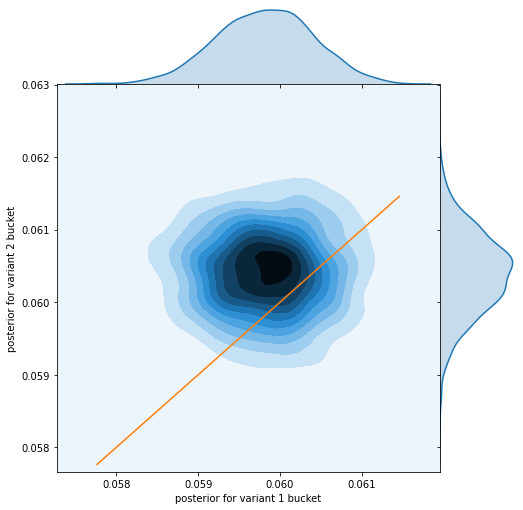

In [24]:
stats = []
num_days = 0
max_days = 10

for ts in date_range[0: max_days]:
    num_days += 1
    if num_days < max_ days:
        closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', False)
    else:
        closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'conversion', True)
    print(getsizeof(globals()))
    stats.append((closs, tloss))

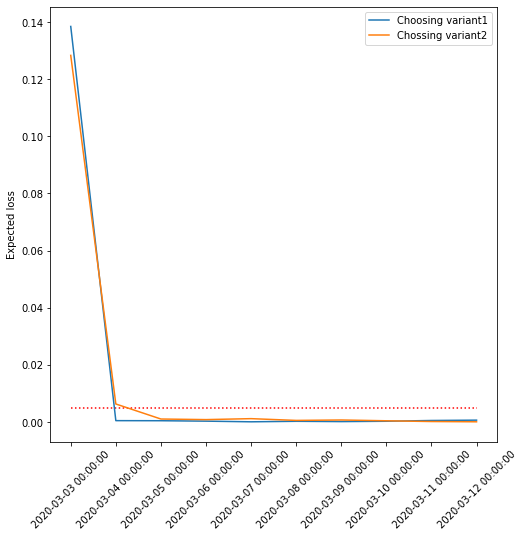

In [25]:
closs, tloss = zip(*stats)
visualize_loss(stats, date_range[0: max_days], 0.005)

In [ ]:
visualize_loss(stats, date_range[0: max_days], 0.005)

In [ ]:
visualize_loss(stats, date_range[0: max_days], 0.005)

In [26]:
for ts in date_range[0: max_days]:
    dt = pd.to_datetime(df['participation_timestamp_rounded_up'])
    idx = dt < Timestamp(ts)
    subxp = df.loc[idx]
    print(len(subxp))

0
7157
61667
109867
151481
194478
222282
245699
288091
321727


In [29]:
df = pd.read_csv('sevenpack/data/exp_385.csv')
metric = 'revenue'
stan_model = sm_revenue

date_range = pd.date_range(start = df.participation_timestamp_rounded_up.min(),
                           end = df.participation_timestamp_rounded_up.max())

In [37]:
idx = df['bucket'] != 'show_modal_forced_selection'
df = df[idx]

In [38]:
date_range = pd.date_range(start = df.participation_timestamp_rounded_up.min(),
                           end = df.participation_timestamp_rounded_up.max())

In [39]:
for ts in date_range[0: max_days]:
    dt = pd.to_datetime(df['participation_timestamp_rounded_up'])
    idx = dt < Timestamp(ts)
    subxp = df.loc[idx]
    print(len(subxp))

0
22084
76247
129505
184579
242812
308051
373162
437670
508932


In [40]:
stats = []
num_days = 0
max_days = 10

for ts in date_range[1: max_days]:
    num_days += 1
    if num_days < max_days:
        closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'revenue', False)
    else:
        closs, tloss = calc_stats_between_buckets_for_column(df, ts, stan_model, 'revenue', True)
    print(getsizeof(globals()))
    stats.append((closs, tloss))

0.02021772939346812 414.3962895927602 8.378152044643674


KeyboardInterrupt: 

## Object-oriented

In [1]:
from bayesian_analysis import BayesianAnalysis

NameError: name 'StanResults' is not defined

In [16]:
df = pd.read_csv('../sevenpack/data/exp_385.csv')

In [17]:
column_for_data_analysis = 'data'

In [18]:
idx = df[column_for_data_analysis] > 0

In [19]:
subdf = df.loc[idx]

In [21]:
len(subdf)

103870

In [22]:
len(df)

4776136

In [23]:
y = idx.values.astype(np.int64)

In [24]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
len(y)

4776136

In [26]:
r = subdf[column_for_data_analysis].values

In [27]:
r

array([ 57.8 ,  15.12, 275.94, ..., 367.04, 546.92, 769.85])

In [28]:
len(r)

103870

In [29]:
dat = {
            'N': len(y),
            'C': y.sum(),
            'prior_alpha' : 1,
            'prior_beta': 1,
            'r': r
        }

In [31]:
fit= sm_revenue.sampling(data=dat, iter=1000, chains=4)

In [41]:
print(fit)

Inference for Stan model: anon_model_e10b5aaf0bda8c3fd55c449a8894ff67.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda                0.02  1.6e-6 6.5e-5   0.02   0.02   0.02   0.02   0.02   1728    1.0
theta               3.3e-3  2.5e-7 1.0e-5 3.3e-3 3.3e-3 3.3e-3 3.3e-3 3.3e-3   1784    1.0
gtv_per_participant   6.64  6.9e-4   0.03   6.59   6.62   6.64   6.66    6.7   1748    1.0
aov                 305.45    0.02   0.97 303.55 304.82 305.45 306.09 307.38   1785    1.0
lp__                -1.2e6    0.03   0.97 -1.2e6 -1.2e6 -1.2e6 -1.2e6 -1.2e6   1109    1.0

Samples were drawn using NUTS at Mon Aug 17 17:40:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [33]:
res = fit.extract(permuted=True)

In [34]:
res

OrderedDict([('lambda',
              array([0.02177639, 0.02171745, 0.02170139, ..., 0.02171757, 0.02174117,
                     0.02165397])),
             ('theta',
              array([0.00326977, 0.00328208, 0.00327279, ..., 0.00326127, 0.00327337,
                     0.0032787 ])),
             ('gtv_per_participant',
              array([6.65990711, 6.61697968, 6.63085542, ..., 6.65923572, 6.64183334,
                     6.60443985])),
             ('aov',
              array([305.83156149, 304.68497703, 305.54979547, ..., 306.62893062,
                     305.49566329, 304.99903106])),
             ('lp__',
              array([-1198584.83288646, -1198585.12930314, -1198584.91884002, ...,
                     -1198585.50835518, -1198584.67810769, -1198585.79465379]))])

In [35]:
res = res['gtv_per_participant']

In [36]:
res

array([6.65990711, 6.61697968, 6.63085542, ..., 6.65923572, 6.64183334,
       6.60443985])

In [38]:
res.dtype

dtype('float64')